<h1>Math</h1>

Here we will be introduced to several topics through various examples

We begin with an easy excercise to give us a high level overview , then we dive deep into the details

The dataset we will use is the SMS Spam collection Dataset (<a href='https://www.kaggle.com/uciml/sms-spam-collection-dataset'>link</a>)

The data consists of 2 columns : 

v1 : labels either spam or ham

v2 : actual text messages


<h4>Basic Outline</h4>

<ol>
<li>Load in data</li>
<li>Preprocess the data</li>
<li>Apply a machine learning Algorithm on Data</li>
<li>Look at the accuracy</li>
</ol>

Lets consider how we preprocess the data , for now we will be using scikit-learn

```python
sklearn.feature_extraction.text.TfidfVectorizer # TF-IDF

sklearn.feature_extraction.text.CountVectorizer # raw counts
```

these have same APi as unsupervised models :

```python
obj = TfidfVectorizer()
obj.fit(sentences)
X = obj.transform(sentences)
# or do both steps in one line
X = obj.fit_transform(sentences)
```

The idea is the same , TF-IDF/raw counts are methods we use to change the text messages into an NxD matrix (discussed later in detail), then , following our motto 'All Data is the same' , we can apply ML model on the matrix

<h1>Code</h1>

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [28]:
# load data
data = pd.read_csv('datasets/spam.csv',encoding = "ISO-8859-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [55]:
# lets one hot encode Y , spam 0 , ham 1
data['v1'][data['v1'] == 'spam'] = 0
data['v1'][data['v1'] == 'ham'] = 1

# next apply feature vectoriser
vectoriser = TfidfVectorizer()
X = vectoriser.fit_transform(data['v2'])

Y = data['v1'].to_numpy().astype('int32')

print(X.shape,Y.shape)

(5572, 8672) (5572,)


In [56]:
# so we see that we obtained an NxD matrix
# now we can apply whatever ML model we want

Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y)

In [57]:
# now lets try naive Bayes , we might as well try any other model
model = MultinomialNB()
model.fit(Xtrain,Ytrain)
print('score: ',model.score(Xtest,Ytest))

score:  0.9547738693467337


In [69]:
# now lets create a wordcloud
# basically that is a picture where more frequent pictures appear larger and less frequent words appear smaller
# we want to know the most common words in spam/ham messages

def plot_word_cloud(X):
    # we just need to concatenate all messages togehter
    words = ''
    for message in X:
        words += message.lower() + ' '
    
    wordcloud = WordCloud(width=600,height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Spam messages :


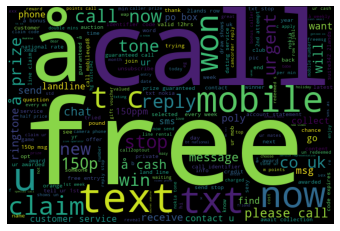

Ham messages :


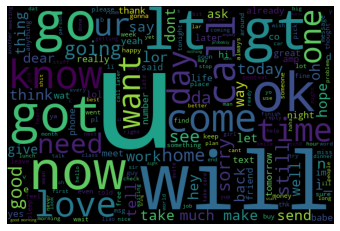

In [70]:
spam_messages = data['v2'][data['v1'] == 0]
ham_messages = data['v2'][data['v1'] == 1]

print('Spam messages :')
plot_word_cloud(spam_messages)
print('Ham messages :')
plot_word_cloud(ham_messages)

<h1>Math</h1>

Next is sentiment Analysis

sentiment is the measure of how positive or negative some text is

we can find the dataset <a href='http://www.cs.jhu.edu/~mdredze/datasets/sentiment/index2.html'>here</a>

These are amazon reviews which come with 5 star ratings , we will work with the electronics category , this can be a regression problem using the 5 star rating as targets , but since the data is already labeled as positive and negative we will do classification

now we want to write code to turn the words into vectors , we start with the simplest example , turning a sentence into a binary bag of words

If a word appears in a sentence , then that word gets a 1 otherwise 0 , here it doesnot matter how many times the word appears , whether the word appears 1 or 10 times , we still get a 1 for that word

ok so what do we need ?

#1 : Input sentence , this needs to be tokenised so "i love coding" $\rightarrow$ ["i","love","coding"]

#2 : we need to consider the shape of our output vector , all feature vectors need to be of same size and all need to represent every sentence of our data , then size of vector = size of vocabulary (V) , so if we have 2000 unique words in data , then feature vectors will be of size 2000


#3 : so we start with a vector of all zeros , x = np.zeros(V) , how do we know which of the entries do we need to flip to 1 , we need to know which word maps to which location in vector , so we need a dictionary/map , key : word , value : unique integer from 0...V-1

so in code it would look something like this :

```python
x = np.zeros(V)
for token in sentence:
    index = word_index_map[token]
    x[index] = 1
```

if we want to take this one step further and use Raw counts :

```python
x = np.zeros(V)
for token in sentence:
    index = word_index_map[token]
    x[index] += 1 # here += instead of =
```

we will work with raw counts , but we still need further processing

recall that we can think of sentences as arrows (vectors) , if we use raw counts , very long sentences will be very long arrows and very short sentences will be very short arrows , so a classifier will need to deal with the fact that vectors are of varying lengths

but we want to make decisions based on the content of document and the relation of the words not the length

so we normalise each feature vector by the total number of words in document , so the feature vector contains only the proportions of each word in the document rather than raw count

After we obtain our NxD matrix , we will be doing logistic regression, as we know normalising is also beneficial for logistic regression which uses the sigmoid function

We can also use other models , but logistic regression is good since we can interpret the weights , so if we have a word 'horrible' , we can look at its corresponding weight , say -1 and so we can interpret that this word has a negative sentiment

In [1]:
import nltk
from nltk import WordNetLemmatizer
import numpy as np
# we will need an XML parser to read data
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
# we will have a review of nltk later but here is a quick tutorial
# lemmatizer turns words into their base form , so we want dogs and dog to be the same word so we can reduce the size of the vocabulary

word_lemmatizer = WordNetLemmatizer()

# also we have some stopwords that we want to remove since they dont really have an actual meaning
# found in stopwords.txt , each word is in a line
stopwords = set(word.rstrip() for word in open('datasets/stopwords.txt'))

In [3]:
positive_reviews = BeautifulSoup(open('datasets/sorted_data_acl/electronics/positive.review').read())
# so each product has multiple keys , the key that concerns us in 'review_text'
positive_reviews = positive_reviews.findAll('review_text')

# again for negative reviews
negative_reviews = BeautifulSoup(open('datasets/sorted_data_acl/electronics/negative.review').read())
negative_reviews = negative_reviews.findAll('review_text')

In [4]:
# now we need to tokenise each review
# we will also remove stop words and lemmatize words
def tokenise(reviews):
    tokenised_reviews = []
    i = 0
    for review in reviews:
        review = review.text.lower()
        # we can use nltk tokeniser 
        tokens = nltk.tokenize.word_tokenize(review)
        # we dont need words that are in stop_words , also wordds of length 2 or less are probably of no meaning
        # also we lemmatize words
        review = [word_lemmatizer.lemmatize(t) for t in tokens if t not in stopwords and len(t)>2]
        tokenised_reviews.append(review)
    return tokenised_reviews

In [5]:
positive_reviews = tokenise(positive_reviews)
negative_reviews = tokenise(negative_reviews)

In [6]:
# now lets form our dictionary
word2idx = {}
idx = 0

all_reviews = positive_reviews+negative_reviews

for review in all_reviews:
    for word in review:
        if word in word2idx:
            continue
        word2idx[word] = idx
        idx+=1

In [7]:
# now lets make our NxD matrix , using raw counts
N = len(all_reviews)
V = len(word2idx)
X = np.zeros((N,V))

for i,review in enumerate(all_reviews):
    for word in review:
        X[i,word2idx[word]] += 1

# normalise
X = X/X.sum(axis=1,keepdims=True)

# get labels , 0 is negative 1 is positive
Y = np.array([1]*len(positive_reviews) + [0]*len(negative_reviews))

In [8]:
print(X.shape,Y.shape)

(2000, 10960) (2000,)


In [12]:
# as we can see we obtained an NxD matrix
# now lets split into train and test sets then use our models
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y)

model = LogisticRegression()
model.fit(Xtrain,Ytrain)
print('score :',model.score(Xtest,Ytest))

score : 0.744


In [13]:
# now lets look at the weights and get the most positive/negative words
weights = model.coef_[0]

# number of words to get
N = 10
# get most positive 10 words (highest weights)
p_idx = np.argpartition(weights*-1, N)[:N]

# get most negative 10 words (least weights)
n_idx = np.argpartition(weights, N)[:N]

# we have the indicies but we need the words , so we reverse the map
idx2word = {v:k for k,v in word2idx.items()}

In [14]:
print('positive words')
positive_words = [idx2word[i] for i in p_idx]
print(positive_words)

print('negative words')
negative_words = [idx2word[i] for i in n_idx]
print(negative_words)

positive words
['perfect', 'excellent', 'easy', 'quality', 'love', 'highly', 'price', 'fast', 'sound', 'speaker']
negative words
['waste', "n't", 'item', 'support', 'return', 'money', 'returned', 'tried', 'then', 'poor']


<h1>Code</h1>

In [1]:
# next lets discover some more features of nltk library
import nltk
# if nltk prompts you that someting is missing
# use nltk.download() to download 

In [8]:
# the first thing we do will be POS (Part Of Speech) tagging
sentence = 'Machine learning is great'
nltk.pos_tag(sentence.split())

[('Machine', 'NN'), ('learning', 'NN'), ('is', 'VBZ'), ('great', 'JJ')]

In [10]:
# NN : noun singular
# VBZ : verb 3rd person singular present 
# JJ : adjective
# for more visit https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [19]:
# next is stemming and lemmatisation
# the basic idea is same we want to reduce word to base form
# stemming , as we will see , is more 'crude'
stemmer = nltk.PorterStemmer()
print(stemmer.stem('wolv'))

lemmatiser = nltk.WordNetLemmatizer()
print(lemmatiser.lemmatize('wolves'))

wolv
wolf


In [21]:
# in our sentiment analysis example , we had both 'returned' and 'return' in the negative words
# lemmatiser treated them as different words
# should we have used stemmer we would have gotten only 'return'

In [35]:
# next is NER (named entity recognition)
# entities : "Albert Einstein" --> 'person' , 'Apple' --> 'organisation'
sentence = 'Albert Einstein was born on March 14, 1879'
# first we get tags
tags = nltk.pos_tag(sentence.split())
# then this is input to Named entity recogniser
tree = nltk.ne_chunk(tags)
print(tree)
tree.draw()

# another example
sentence = 'Steve Jobs was the founder of Apple Corp.'
tags = nltk.pos_tag(sentence.split())
tree = nltk.ne_chunk(tags)
print(tree)
tree.draw()

(S
  (PERSON Albert/NNP)
  (PERSON Einstein/NNP)
  was/VBD
  born/VBN
  on/IN
  March/NNP
  14,/CD
  1879/CD)
(S
  (PERSON Steve/NNP)
  (PERSON Jobs/NNP)
  was/VBD
  the/DT
  founder/NN
  of/IN
  (ORGANIZATION Apple/NNP)
  Corp./NNP)


<h1>Math</h1>

Next we introduce Latent Semantic Analysis

previously we solved problems where we used word counts , but what if when counting words we have multiple words with same meaning , or what if when counting we have one word with multiple meanings ?

Synonymy : multiple words with the same meaning 

<ul>
    <li>'buy' and 'purchase'</li>
    <li>'big' and 'large'</li>
    <li>'quick' and 'speedy'</li>
</ul>

Polysemes : One word with multiple meanings 

<ul>
    <li>'Man'<ul>
    <li>A Human as opposed to an Animal</li>
    <li>A Male as opposed to a Female</li>
</ul>
</li>
    <li>'Milk'<ul>
    <li>I am going to milk it (as a verb)</li>
    <li>I will drink milk (as a noun)</li>
</ul>
</li>
</ul>

<h4>Latent Variables</h4>

one way to solve Synonymy problem is to combine words with similar meaning

$z = 0.6*computer + 0.5*PC + 0.6*laptop $

So for example we probably see the words 'computer' , 'PC' , 'laptop' together very often , that means they are highly correlated , we may think of a latent/hidden variable that represents all of them , hence "Latent Semantic Analysis"

The job of LSA is to find these variables and transform the original data into these new variables , and hopefully the dimensionality of this data is much smaller than the original , which speeds up our computation

As for polysemy there seem to be conflicting viewpoints as to whether LSA helps or not

<h1>Math</h1>

Now we will look at the underlying math behind LSA which is a technique from linear algebra called SVD (Singular-Value Decomposition)

we know that we will apply LSA to synonyms , which are multiple words that mean the same thing , if we have words 'small' and 'little' , we may argue that they are redundant and could be replaced by a single word which reduces the complexity of language model , the goal of SVD is to reduce redundancy

How does redundancy appear when we talk about numbers ?

<img src='extras/23.1.PNG' width = '300'></img>

consider a scatter plot like this , we can see that there is a relationship between the independant variable and the dependant variable

we can see that there is a linear relatioship between lean body mass and muscle strength , so we can say that one of these variables is redundant , meaning that , if we know the lean body mass we can accurately predict the strength (and vice versa)

if we want a compact representation of attributes related to athletic performance then maybe we only need to know one of these variables since the other one can be predicted from it

The advantages of this may not be clear when we have only two variables, but with high dimensional data , we end up doing lots of savings , if we have  1 million dimensions and we can end up with 5 then thats great !

A more practical example for dimensionality reduction would be movie recommendations !

In movie recommendations we build a user-movie ratings matrix which is very similar to NLP where we have a term document matrix

<img src='extras/23.2.PNG' width='600'></img>

In the user-movie matrix , each entry tells us what that user rated this movie , or in other words how much did that user like this movie

In a term document matrix we have counts to tell us how many times a term appears in that document , but if we think of a term as a person , we might say each entry tells us 'how much this term likes this document'

A user-movie matrix would have high dimensionality since there are too many users and we would like to reduce dimensionality

we might look at the matrix and find out that two movies are similar

<img src='extras/23.3.PNG' width='600'></img>

the movies are similar in the sense that all people who liked 'Power Rangers' liked 'Transformers' and all the people who did not like 'Power Rangers' also didnot like 'Transformers' , so the movies have been rated very similarly by people who watched them , we can think of these 2 rows (ratings) as vectors which are very close to one another

But the dimensionality would be very high since there are many users , what can we do is try thinking of these movies as having some latent dimensions

for ex both 'Transformers' and 'Powe rangers' are :

<ul>
    <li>Action-adventure</li>
    <li>Superheroes with superpowers (aliens)</li>
    <li>Main characters are teenagers</li>
    <li>Physical combat</li>
    <li>Robots</li>
</ul>

So we have reduced the dimensionality of these two movies down to 5 dimensions , if we pick another movie that had these 5 attributes , then it is very likely that the people that like 'Power Rangers' and 'Transformers' will like it too

of course we cant watch every single movie and assign latent factors manually , the whole idea behind the process is that it is automated using mathematics , in this way the results may or mat not be human-interpretable  , although we can look ourselves to see if we notice patterns , for ex: we may find that 'Power Rangers','Transformers','Ninja Turtles' all have same latent factor , so we might think of that factor as the 'children superhero movies' factor

ok , so how would this look like in code ?

Input X (shape NxD)

Output Z (shape Nxd , where d<<D , default d = 2)
 
<img src = 'extras/23.4.PNG' width = '300'></img>

```python
model = TruncatedSVD()
model.fit(X)
Z = model.transform(X) # Nxd output matrix , d<<D , default d = 2
# or in one step
Z = model.fit_transform(X)
```

since the reduced dimensionality = 2 , we can also plot the points , note that d can be any number up to and including D , if d = D , it is true that we havent made any dimensionality reduction , but we still changed the feature representation in some way

Here is an example of SVD on MNIST dataset (D = 28x28 = 784 $\rightarrow$ d = 2) :

<img src = 'extras/23.5.PNG' ></img>

As we can see digits which are the same appear to be clustered together , this shows that SVD likes to preserve the structure of the data while at the same time reducing the dimensionality

we will discuss SVD thoroughly later 

<h1>code</h1>

In [1]:
# the data we will use is all_book_titles.txt
# contains book titles , one on each line
# each title will serve as a document
# we will represent words as vectors then plot them
# hoepfully similar words appear close to each other
import nltk
import numpy as np
from nltk import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
#import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

In [2]:
word_lemmatizer = WordNetLemmatizer()
stopwords = set(word.rstrip() for word in open('datasets/stopwords.txt'))
titles = [line.rstrip() for line in open('datasets/all_book_titles.txt')]

In [3]:
def tokenise(docs):
    tokenised_docs = []
    i = 0
    for doc in docs:
        tokens = nltk.tokenize.word_tokenize(doc)
        doc = [word_lemmatizer.lemmatize(t) for t in tokens if t not in stopwords and len(t)>2]
        tokenised_docs.append(doc)
    return tokenised_docs

In [4]:
titles = tokenise(titles)

In [5]:
# now lets form our dictionary
word2idx = {}
idx = 0

for title in titles:
    for word in title:
        if word in word2idx:
            continue
        word2idx[word] = idx
        idx+=1

In [6]:
# now lets make our NxD matrix , using raw counts
N = len(titles)
V = len(word2idx)
X = np.zeros((N,V))

for i,title in enumerate(titles):
    for word in title:
        X[i,word2idx[word]] += 1

# normalise
X = X/X.sum(axis=1,keepdims=True)

In [7]:
# now X is a matrix where rows are titles and columns are words a document-term matrix
# we want each row to be a word and each column to be a feature of that word , a term-document matrix
# so we need X.T
X = X.T

In [8]:
# now we can make SVD
Z = TruncatedSVD().fit_transform(X)

In [9]:
print(Z.shape,X.shape)

(2548, 2) (2548, 2373)


<IPython.core.display.Javascript object>


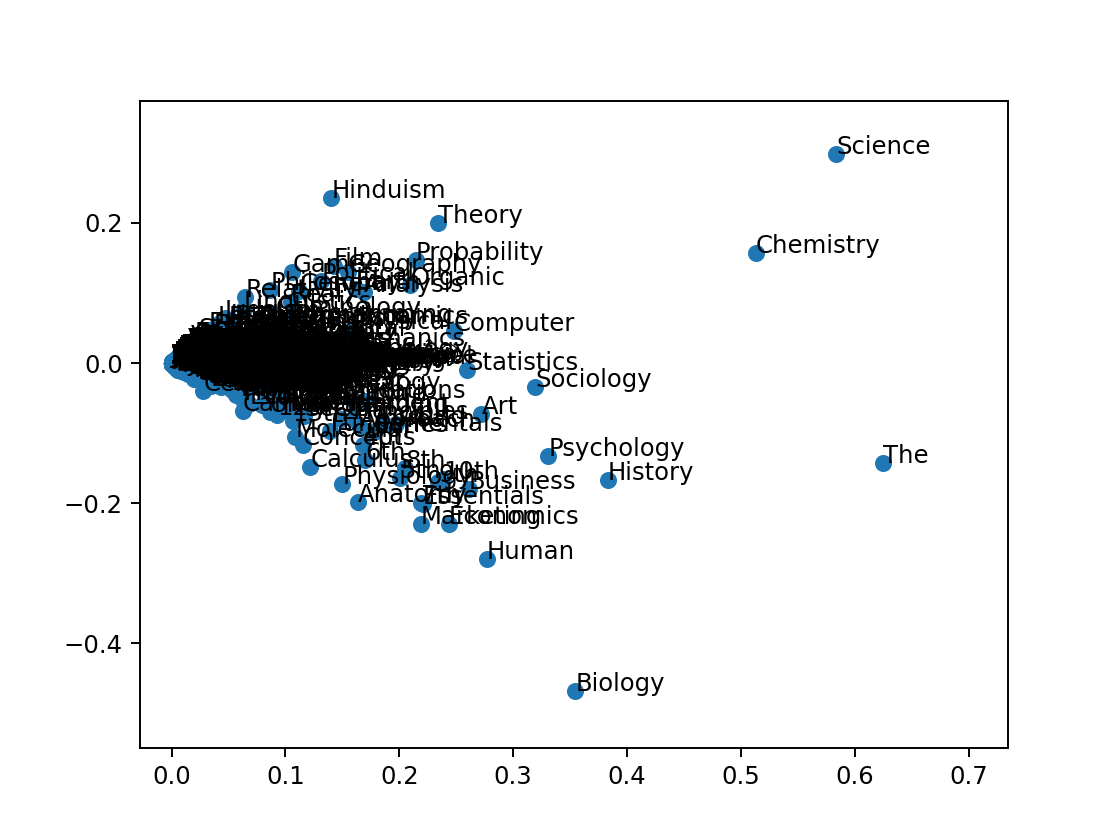

In [11]:
# as we can see Z has only 2 dimensions now lets plot each word
plt.scatter(Z[:,0],Z[:,1])
idx2word = {v:k for k,v in word2idx.items()}
for i in range(len(word2idx)):
    plt.annotate(s=idx2word[i],xy=(Z[i,0],Z[i,1]))
plt.show()

<h1>Math</h1>

Now lets go back to our original purpose , dealing with Synonymy and Polysemy

Synonymy : 

we want to find words with similar meanings 

we can imagine that if one word can be equivalently used in place of another , then their vector structure should be similar and hence they should appear together

<img src='extras/23.8.PNG' width='500'></img>

Polysemy :

recall that this means that the same word that can mean two different things

for example , consider the word 'Bat'

<img src='extras/23.9.PNG' width='500'></img>

This word should appear close to other words that occur in documents about baseball at the same time it should appear close to words that occur in documents about animals

Another for an application is Information retrieval

Information Retreival :

By transforming each word into a vector , we can then build a search engine which would basically work as a nearest neighbor search from query to documents

Each document is represented by a vector , we have a query that we also transform into a vector , and then we ask which document vector appears closest to query vector , then we return these documents

of course dimensionality reduction helps here , since a naive implementation needs O(ND) time so O(Nd) helps , alos we can be confident that distance is based on signal not noise

for ex: words like 'and','in','to' would appear in lots of documents and we would consider that noise

note how this method has an important advantage , if we seatch for the word 'doctor' , I dont want to get pages only containing the word 'doctor' , in fact this would be very bad , since one can build a page that repeatd Dr 1000x and then it appears first in search results (this was common in early days of the net)

I want to measure similarity in some other sense , maybe also include documents that contain "physician","nurse","surgeon"

That cannot be accomplished by string matching - we need mathematical techniques like LSA

<h1>Math</h1>

There are also other DR (dimensionality reduction) techniques (Sci-Kit Learn documentation has a page devoted to DR models)

<ul>
<li>Independant Component Analysis (ICA) , particulary interesting since it attempts to solve the 'cocktail party problem' , that is , we are in a noisy room , we have sound coming from everywhere , and someone is trying to talk to us , and we want to single out his voice and understand what he is trying to say , so it attempts to seperate each of the individual component signals given only the mixed signal <ul>
<li>What we hear = A*signal1 + B*signal2 + noise</li>
</ul></li>
<li>Factor Analysis</li>
</ul>

<h3>Drawbacks</h3>

one of the drawbacks of SVD,PCA (we will see this later too),ICA,FA is that they are all linear models z = Wx

we have seen how linearm models are limited (for ex recall the donut problem) , there exist nonlinear model for DR too , examples are :

<ul>
    <li>t-SNE(we will also see this later)</li>
    <li>Isomap</li>
    <li>Locally Linear Embedding</li>
    <li>Locally Linear Embedding</li>
    <li>Spectral Embedding</li>
    <li>Multi-Dimensional Scailing
</li>
</ul>





<h1>Math</h1>

Now we want to talk about a popular topic called article spinning which is a very useful tool for Internet marketers

Ideally humans would create content , but back in the old days people would repeat a keyword 1000 times in invisible text on their webpages in order to rank higher on Search Engines

Eventually Search Engines caught onto this , then marketers started to steal content from others and put it on their site , of course Search Engines want to prevent this , nowadays duplicate content is heavily penalised

One thing marketers have always been interested in is article spinning , that is taking in an existing article that is very popular and modifying certain words and phrases so it does not exactly match the original , which then prevents search engines from marking it as duplicate content

well how do we do this ?

We can imagine that synonyms play a big role , if we just replace certain words with different words that meant the same thing , we will end up with a different article but with the same meaning

of course things dont always work that well in reality , ex :

Original :

"Udemy.com is a <u>platform</u> or <u>marketplace</u> for online <u>learning</u>"

Then replace underlined words with synonyms from thesaurus.com , the sentence becomes

"Udemy.com is a <u>platform</u> or <u>forum</u> for online <u>research</u>"

which makes no sense , context is important!

so the idea is that we would like to use the surrounding words to influence the replacement of the current word

<h1>Math</h1>

So how do we model the probability of a word giving the surrounding words ?

say we have a document of words , $w_1,w_2,...,w_3$ , we can then model the probability of any word $w_i$ using $w_1,...,w_{i-1},w_{i+1},...,w_N$

Probabilistically we want to model :

$$ P(w_i | w_1,...,w_{i-1},w_{i+1},...,w_N)$$

of course that wont really work , if we consider every word in the document , then only that document itself would match it exactly , since only this document has exactly $w_1,w_2,...,w_N$ , that would only give us 1 data point to learn from which is not useful , we need something like markov models where we only consider the closest words

<h3>Trigrams</h3>

specific instance of "N-gram" , where N = 3 , we will model $P(w_i|w_{i-1},w_{i+1})$ , one way to implement this is using a dictionary , with $(w_{i-1},w_{i+1})$ as key , and lookup w(i) (we discuss it in more detail)

of course we wont replace every word in the document since that would probably not give us anything useful , so we would make the decision to replace a word based on some small probability , p = 0.2

<h1>Math</h1>

Now we want to discuss Trigrams and how can we use them for article spinning , we already discussed then concept of N-grams (see part 22 ) , but this will also serve as a good introduction

<h3>N-grams</h3>

The term "gram" , as used in Bigram (2) , Trigram (3) , N-gram (N) , etc refers to a list of consecutive words

So a Bigram is a list of two consecutive words , a Trigram is a list of three consecutive words and an N-gram is a list of N consecutive words

for ex , consider the sentence :

"The quick brown fox jumps over the lazy dog"

Bigrams : (the,quick),(quick,brown),(brown,fox),...

Trigrams : (the,quick,brown),(quick,brown,fox),(brown,fox,jumps),...

<h3>Language Modeling</h3>

This means we represent the N-grams as probabilities (typically using the last N-1 words to model the distribution of the Nth word )

$$p(w_t | w_{t-1} , w_{t_2} , ... , w_{1})$$

for ex , take the sentence "I love dogs and ... "

Now we want to predict the last word , here are the possibilities :

<ul>
<li>I love dogs and cats</li>
<li>I love dogs and frogs</li>
<li>I love dogs and pizza</li>
<li>I love dogs and hello</li>
</ul>

for each of the words {cats,frogs,pizza,hello} we are going to assign a probability (we will se later how to calculate) , but for now , using intuition we know that "cats" should have a high probability while "hello" should have low (or zero) probability

In ML , we usually use N = 2 (Bigram) N = 3 (Trigram)

What if we pick a large value for N , say N = 10

first , some sentences are not even that long , so our model wont work for shorter sentences

But also think of a long sentence :

"It was the best of times , it was the worst of times"

Remember we are taking everything except the last word and we are trying to predict that last word , the problem is that there is only one way that sentence can end , there is no other word that can be used to appropriately end this sentence , this is a problem , why ?

<h3>Measuring probabilities</h3>
    
Lets take an example , bigrams that start with "I" , in our text corpus , these bigrams appear:
    
<ul>
<li>"I love" appears 25 times</li>
<li>"I like" appears 22 times</li>
<li>"I walked" appears 18 times</li>
<li>"I am" appears 30 times</li>
<li>"I will" appears 28 times</li>
</ul>
    
our probabilities will be:
    
<ul>
<li>$p(love|I) = count(I\rightarrow love) / count(I) = 25/123$</li>
<li>$p(like|I) = count(I\rightarrow like) / count(I) = 22/123$</li>
</ul>

In general :

we can say that the probability of going from $w_{t-1}$ to $w_{t}$ is just the count of how many times we went form $w_{t-1}$ to $w_t$ divided by total number of times $w_{t-1}$ appears

This can be extended to trigrams and N-grams , by counting the entire sequence then dividing by the count of entire sequence excluding the last word

Bigram:

$$p(w_t|w_{t-1}) = \frac{count(w_{t-1} \rightarrow w_t)}{count(w_{t-1})}$$

Trigram:

$$p(w_t|w_{t-1},w_{t-2}) = \frac{count(w_{t-2} \rightarrow w_{t-1} \rightarrow w_t)}{count(w_{t-2} \rightarrow w_{t-1})}$$

N-gram:

$$p(w_t|w_{t-1},w_{t-2},\cdots,w_{t-N+1}) = \frac{count(w_{t-N+1} \rightarrow \cdots \rightarrow w_{t-1} \rightarrow w_t)}{count(w_{t-N+1} \rightarrow \cdots \rightarrow w_{t-1})}$$

<h3>Longer grams</h3>

So now we can understand why modelling ver large sentences does not work , back to our example :

"It was the best of times , it was the worst of times"

Probably this is the only times this sentence occur in our dataset , so our counts would be :

count(it was the best of times , it was the wors of) = 1

count(it was the best of times , it was the wors of times) = 1

p(times | it was the .. ) = 1/1

But following the frequentist probability rules , we know one sample is not really good enough to get a good measure of this probability , especially when we want to model novel sentences that do not exist in training dataset 

<h3>shorter grams</h3>

Instead of conditioning on all previous words , just use the last 2 

so in our ex , using a trigram , we condition on "worst of" , so we are modelling the probability of all words given that the previous two word were "worst of" , this time we can think of lots of examples that would make sense , so we may easily find in our corpus :

<ul>
    <li>worst of all</li>
    <li>worst of the (bunch)</li>
    <li>worst of the three</li>
    <li>worst of any</li>
</ul>

so now , there are many more words in which this sentence may end if we only look at the last 2 words , this allows us to collect more data and arrive at more meaningful probabilities since the number of samples we are using to calculate each probability is now greater

<h3>Markov Assumption</h3>

if we say that the current word depends only on the previous word , we call this first-order markov , so a Bigram model is a first-order Markov model , if we say that the current word depends on the previous 2 words then that is a second-order Markov , so a Trigram model is a second-order markov model

<h3>Article Spinning</h3>

what we would like to do is replace some words in the document with new words , but the replacement should be "appropriate" , how do we do that ?

well we can use a markov model , pick a three word sequence , then assume that the first two words are fixed , then use the trigram distribution to sample a new word to replace the third word , this repalces the third word with a new third word , and we know this third word must have followed these two words somewhere in our training set , maybe not this document , but some other document in text corpus , that why it has more than 0 probability which givesus more than 0 chance of sampling it

so for example :

"The <u>quick brown fox</u> jumps over the lazy dog"
    
we might replace fox by rabbit , this means that the phrase "quick brown rabbit" appeared somewhere in our dataset

<h3>context</h3>

one thing we might do (and which we will actually do in code) is not only look at past words but also future words

$$p(w_t|w_{t-1},w_{t+1})$$




 <h1>code</h1>

In [1]:
# we will use the Amazon reviews datasets 
# first we will load in all (positive) the reviews , these will be our training corpus
# then we will use these to build our trigram model
# finally we will choose some random review and spin it !

In [2]:
import nltk
import numpy as np
# we will need an XML parser to read data
from bs4 import BeautifulSoup
import string

In [38]:
punct = list(string.punctuation)

def tokenise(reviews):
    tokenised_reviews = []
    i = 0
    for review in reviews:
        review = review.text.lower()
        tokens =  nltk.tokenize.word_tokenize(review)
        # we will remove punctuation
        review = [t for t in tokens if t not in punct]
        tokenised_reviews.append(review)
    return tokenised_reviews

In [39]:
positive_reviews = BeautifulSoup(open('datasets/sorted_data_acl/electronics/positive.review').read())
positive_reviews = positive_reviews.findAll('review_text')
positive_reviews = tokenise(positive_reviews)

In [40]:
# the keys are (w(t-1),w(t+1))
# the value is a dictionary , w(t) : prob 
trigram = {}
# first lets get all counts

for review in positive_reviews:
    for i in range(1,len(review)-1): # so review[i] is always middle word
        context = (review[i-1],review[i+1])
        mid_word = review[i]
        if context not in trigram:
            trigram[context] = {}
        trigram[context][mid_word] = trigram[context].get(mid_word,0) + 1

In [41]:
# now lets change these to probabilities
# for each context , we divide the count of eaach word by the total of the counts of words within this context

for context,word2count in trigram.items():
    counts = word2count.values()
    total_count = sum(counts)
    for word,count in word2count.items():
        trigram[context][word] = count/total_count

In [42]:
# now lets spin an article

def spin(article,p_change=0.2): # # probability of changing a word
    spinned_article = []    
    
    for i in range(1,len(article)-1): 
        context = (article[i-1],article[i+1])
        mid_word = article[i]
        
        if np.random.uniform() < p_change: # so lets change the word
            # first we want to get all owrd within this context and their porbabilities
            words = list(trigram[context].keys())
            probs = list(trigram[context].values())
            # now we use the probabilities to sample a word from the words
            word_idx = np.random.choice(len(words),1,p=probs)[0]
            word = words[word_idx]
            spinned_article.append(word)
        else:
            spinned_article.append(mid_word)
    # remeber to add first and last words
    
    return [article[0]] + spinned_article + [article[-1]]

In [43]:
# now lets get some random articles and try to spin them
def try_spin(p_change=0.2):
    while True:
        idx = np.random.choice(len(positive_reviews),1)[0]
        article = positive_reviews[idx]
        spinned_article = spin(article,p_change)
        print('Original article \n')
        print(' '.join(article))
        print('\nSpinned article \n')
        print(' '.join(spinned_article))
        r = input('\n One more Y/n :')
        if r.lower() == 'n':
            break

In [26]:
try_spin(p_change=0.4)
# unimportant note : this example was tried when words where lemmatised so 'was' became 'wa'
# removed lemmatiser but left the example since it is good

Original article 

we received our dlp tv stand in record time we had wanted to get it for a new tv that wa being delivered that weekend we ordered on i think a tuesday and it wa at our office on friday it wa in excellent shape and we had no trouble putting it together the tv fit perfectly

Spinned article 

we received our dlp tv stand in some time we had wanted to get them for a hi-res tv that wa being delivered that weekend we ordered on i think a tuesday and it wa at our office on friday it wa in good detail and we had no trouble buying it wa the tv fit perfectly

 One more Y/n :n


In [53]:
try_spin(p_change=0.4)

Original article 

these speakers are awesome for the price they charge your ipod even when the unit is off the sound quality is great for around 50 bucks i bought these for traveling and they are small enough to fit in a suitcase without taking up too much room they also stack so they do n't take up much counter space i ca n't say enough about the sound quality they are great

Spinned article 

these headphones are perfect for the price they charge your ipod and with the unit is off the sound quality is great for a 50 bucks i chose this for awhile and they are long enough to fit in a suitcase without picking up so much room they also stack so i do n't take up much counter space i ca n't say enough and the sounds quality they are great

 One more Y/n :n


In [27]:
# feel free to try more examples
# the result is A very bad article spinner :)

<h3>Math</h3>

Now lets discuss some modifications that may lead to better results

#1 : condition on more words

$$p(w_t | w_{t-2} , w_{t-1} , w_{t+1} , w_{t+2})$$

maybe only two words are not enough context for whole sentence to make sense

the downside is that if our context size gets too large , dataset wont have enough samples to accurately calculate a probability

But this can be solved by augmenting our dataset using text from other sources e.h. Wikipidea

#2 : condition only on past words

$$p(w_t | w_{t-1} , w_{t-2})$$

$$p(w_t | w_{t-1} , w_{t-2} , w_{t-3})$$

$$p(w_t | w_{t-1} , w_{t-2} , w_{t-3} , w_{t-4})$$

we made the assumption that future words matter , but we dont know the case unless we test it , again , we dont have to limit ourselves to two words we can condition on more

#3 : Asymmetric context

$$p(w_t|w_{t-2},w_{t-1},w_{t+1})$$

the left and right context windows do not necessarily need to be symmetric , so we can condition on past two words and next one word and so on

#4 : Other features

$$p(w_t | pos_t , w_{t-1} , w_{t+1})$$

We can trt conditioning on other features that are not simply words , ex : part-of-speech tags

this might help us acheive more grammatically correct sentences , so for ex we can sample the current word based on a set of words that have the same POS tag as original word , that way we wont change the POS which hopefully makes sentence make more sense 

we can even use past POS as well

$$p(w_t | pos_t,pos_{t-1},pos_{t-2},w_{t-1},w_{t+1})$$